##De-identification in Spark OCR

####0 Import libs

In [0]:
import os
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline, PipelineModel

import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.base import *
from sparknlp_jsl.annotator import *
from sparknlp.pretrained import ResourceDownloader

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

sparkocr.info()

Spark version: 3.0.0.dev0
Spark NLP version: 3.1.2
Spark OCR version: 3.4.1

###1 Define Spark NLP de-identification pipeline

In [0]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

###2 Define Spark OCR pipeline

In [0]:
# Read Pdf as image
pdf_to_image = PdfToImage()\
  .setInputCol("content")\
  .setOutputCol("image_raw")\
  .setResolution(400)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setWithSpaces(True) \
    .setConfidenceThreshold(70)

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(100) \
    .setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.black)
    
# OCR pipeline
deid_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ][OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
[ | ][OK!]

###3 Prepare documents

In [0]:
%sh
OCR_DIR=/dbfs/tmp/deid_ocr3
if [ ! -d "$OCR_DIR" ]; then
    mkdir $OCR_DIR
    cd $OCR_DIR
    for i in {0..3}
    do
      wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/MT_0$i.pdf
    done
fi

In [0]:
display(dbutils.fs.ls("dbfs:/tmp/deid_ocr3/"))

path,name,size
dbfs:/tmp/deid_ocr3/MT_00.pdf,MT_00.pdf,528022
dbfs:/tmp/deid_ocr3/MT_01.pdf,MT_01.pdf,165397
dbfs:/tmp/deid_ocr3/MT_02.pdf,MT_02.pdf,309334
dbfs:/tmp/deid_ocr3/MT_03.pdf,MT_03.pdf,248334


In [0]:
file_path='dbfs:/tmp/deid_ocr3/*.pdf'
pdfs = spark.read.format("binaryFile").load(file_path)
pdfs.show()

+--------------------+-------------------+------+--------------------+
 path| modificationTime|length| content|
+--------------------+-------------------+------+--------------------+
dbfs:/tmp/deid_oc...|2021-07-11 14:33:18|528022|[25 50 44 46 2D 3...|
dbfs:/tmp/deid_oc...|2021-07-11 14:33:19|309334|[25 50 44 46 2D 3...|
dbfs:/tmp/deid_oc...|2021-07-11 14:33:19|248334|[25 50 44 46 2D 3...|
dbfs:/tmp/deid_oc...|2021-07-11 14:33:19|165397|[25 50 44 46 2D 3...|
+--------------------+-------------------+------+--------------------+

In [0]:
from sparkocr.databricks import display_images
display_images(PdfToImage().transform(pdfs).limit(2))

Origin: dbfs:/tmp/deid_ocr3/MT_00.pdf 
 Resolution: 300 dpi 
 Width: 2250 px 
 Height: 3249 px 
 Mode: Greyscale 
 Number of channels: 1 
 
 
 
 
 
 
 
 Origin: dbfs:/tmp/deid_ocr3/MT_00.pdf 
 Resolution: 300 dpi 
 Width: 2250 px 
 Height: 3249 px 
 Mode: Greyscale 
 Number of channels: 1

###4 Run pipeline

In [0]:
deid_results = deid_pipeline.transform(pdfs).cache()

#### Display Ner chuncs

In [0]:
display(deid_results.select("ner_chunk").limit(2))

ner_chunk
"List(List(chunk, 120, 129, 2093-01-13, Map(entity -> DATE, sentence -> 0, chunk -> 0, confidence -> 1.0), List()), List(chunk, 133, 142, David Hale, Map(entity -> NAME, sentence -> 0, chunk -> 1, confidence -> 0.9675), List()), List(chunk, 158, 174, Hendrickson , Ora, Map(entity -> NAME, sentence -> 0, chunk -> 2, confidence -> 0.9865667), List()), List(chunk, 557, 571, August 24, 2007, Map(entity -> DATE, sentence -> 5, chunk -> 3, confidence -> 0.978075), List()), List(chunk, 656, 670, August 20, 2007, Map(entity -> DATE, sentence -> 6, chunk -> 4, confidence -> 0.991175), List()), List(chunk, 694, 708, August 31, 2007, Map(entity -> DATE, sentence -> 7, chunk -> 5, confidence -> 0.920425), List()), List(chunk, 998, 1005, May 2006, Map(entity -> DATE, sentence -> 10, chunk -> 6, confidence -> 0.98235), List()))"
"List(List(chunk, 208, 221, US Post Office, Map(entity -> LOCATION, sentence -> 3, chunk -> 0, confidence -> 0.5585334), List()), List(chunk, 347, 370, Tuesday, August 14, 2007, Map(entity -> DATE, sentence -> 8, chunk -> 1, confidence -> 0.94046664), List()), List(chunk, 1450, 1455, Monday, Map(entity -> DATE, sentence -> 32, chunk -> 2, confidence -> 0.9998), List()), List(chunk, 1637, 1646, March 2005, Map(entity -> DATE, sentence -> 35, chunk -> 3, confidence -> 0.97965), List()), List(chunk, 1941, 1941, Y, Map(entity -> NAME, sentence -> 36, chunk -> 4, confidence -> 0.851), List()), List(chunk, 2055, 2064, March 2006, Map(entity -> DATE, sentence -> 36, chunk -> 5, confidence -> 0.97545), List()))"


####Display coordinates of text which need to hide

In [0]:
display(deid_results.select('coordinates').limit(2))

coordinates
"List(List(0, 0, 693.0, 1013.0, 272.0, 40.0, 0.0, 0), List(1, 0, 1011.0, 1009.0, 253.0, 44.0, 0.0, 0), List(2, 0, 545.0, 1153.0, 423.0, 44.0, 0.0, 0), List(3, 0, 493.0, 2066.0, 358.0, 53.0, 0.0, 0), List(4, 0, 493.0, 2210.0, 358.0, 53.0, 0.0, 0), List(5, 0, 493.0, 2280.0, 358.0, 53.0, 0.0, 0), List(6, 0, 1668.0, 2597.0, 235.0, 45.0, 0.0, 0))"
"List(List(0, 1, 1189.0, 910.0, 335.0, 44.0, 0.0, 0), List(1, 1, 1328.0, 1153.0, 607.0, 56.0, 0.0, 0), List(2, 1, 2262.0, 2853.0, 196.0, 56.0, 0.0, 0), List(4, 1, 941.0, 3284.0, 25.0, 41.0, 0.0, 0), List(5, 1, 1504.0, 3355.0, 284.0, 44.0, 0.0, 0))"


###4 Display original and de-identified results

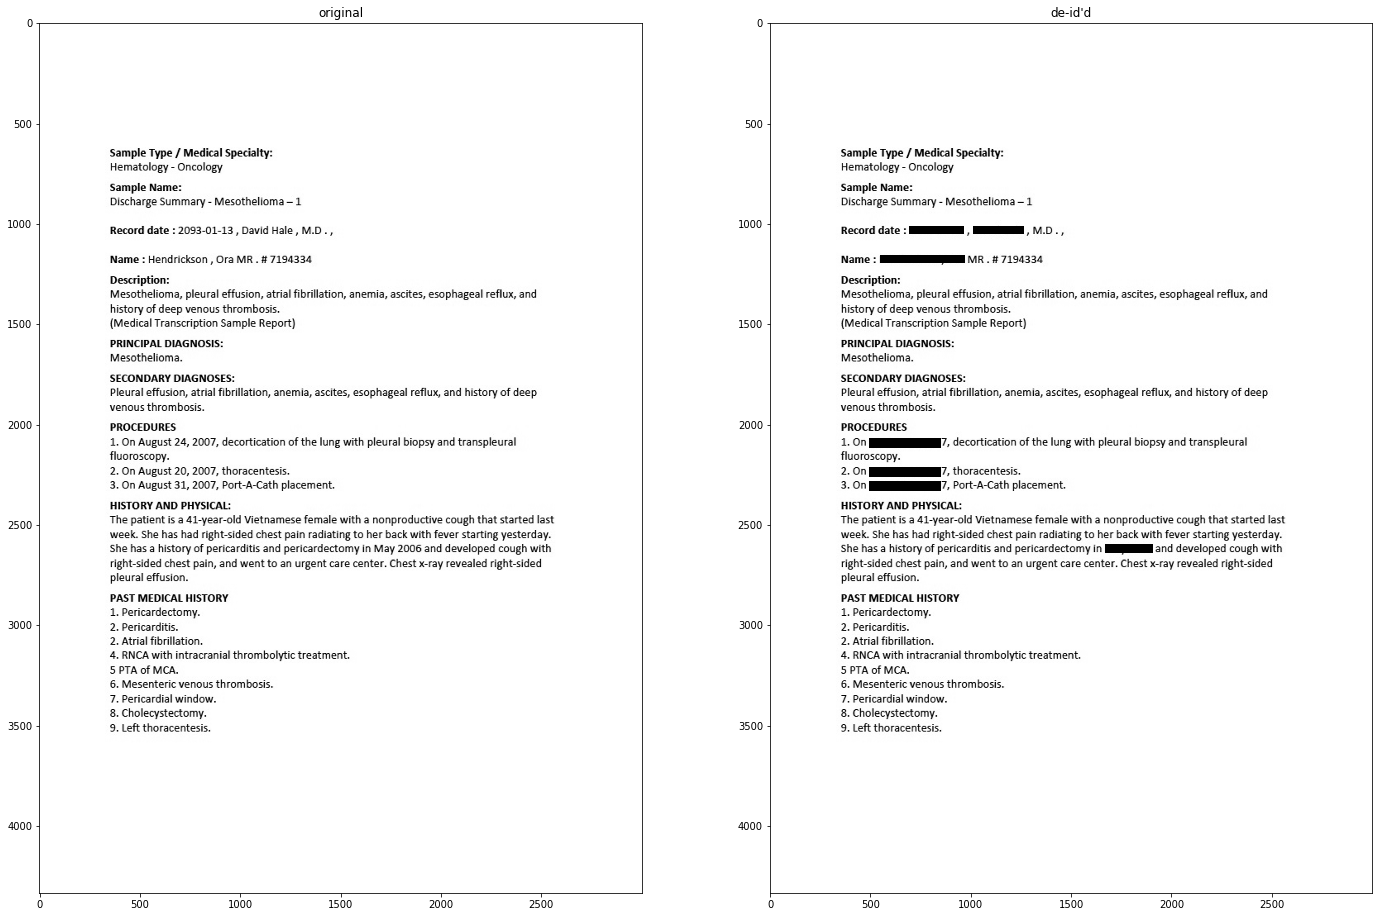

In [0]:
r = deid_results.select("image_raw", "image_with_regions").collect()[0]
img_orig = r.image_raw
img_deid = r.image_with_regions

img_pil_orig = to_pil_image(img_orig, img_orig.mode)
img_pil_deid = to_pil_image(img_deid, img_deid.mode)

plt.figure(figsize=(24,16))
plt.subplot(1, 2, 1)
plt.imshow(img_pil_orig, cmap='gray')
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(img_pil_deid, cmap='gray')
plt.title("de-id'd")
plt.show()